In [1]:
import datetime as dt
from pathlib import Path
import seaborn as sns
import os
import requests
import pandas as pd
import yfinance as yf
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
%matplotlib inline

In [2]:
# Get historical data in YAHOO FINANCE HISTORICAL DATABASE
tsla = yf.Ticker("TSLA")
volks = yf.Ticker("VOW3.DE")
tesla_hist = tsla.history(period="5y")
vow_hist = volks.history(period="5y")
# Create an empty DataFrame for TESLA AND VOLKS.DE closing prices
t_v_closing_prices = pd.DataFrame()
# Fetch the closing prices of TESLA AND VOLKS.DE
t_v_closing_prices["TESLA"] = tesla_hist["Close"]
t_v_closing_prices["VOLKS"] = vow_hist["Close"]
t_v_closing_prices.tail()

,TESLA,VOLKS
Date,,
2020-11-02,400.510010,127.779999
2020-11-03,423.899994,131.740005
2020-11-04,420.980011,132.080002
2020-11-05,438.089996,135.919998
2020-11-06,429.950012,133.160004


In [3]:
load_dotenv()

True

In [4]:
# Open S&P 500 historical prices
file_path = Path("Resources\S&P500_5years.csv")
sp500 = pd.read_csv(file_path, parse_dates=True, index_col="Date", infer_datetime_format=True)
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-04,2110.600098,2114.590088,2096.979980,2102.310059,2102.310059,4078870000
2015-11-05,2101.679932,2108.780029,2090.409912,2099.929932,2099.929932,4051890000
2015-11-06,2098.600098,2101.909912,2083.739990,2099.199951,2099.199951,4369020000
2015-11-09,2096.560059,2096.560059,2068.239990,2078.580078,2078.580078,3882350000
2015-11-10,2077.189941,2083.669922,2069.909912,2081.719971,2081.719971,3821440000


In [5]:
# Fetch the closing prices of S&P500
sp500_closing_prices = pd.DataFrame()
sp500_closing_prices["S&P500"] = sp500["Close"]
sp500_closing_prices

,S&P500
Date,
2015-11-04,2102.310059
2015-11-05,2099.929932
2015-11-06,2099.199951
2015-11-09,2078.580078
2015-11-10,2081.719971
...,...
2020-10-28,3271.030029
2020-10-29,3310.110107
2020-10-30,3269.959961


In [6]:
#check null and cleaning data
sp500_closing_prices.isnull().sum()

S&P500    0
dtype: int64

In [7]:
###Set Alpaca API key and secret
alpaca_api_key = os.getenv("api_key_id")
alpaca_secret_key = os.getenv("secret_api_key")
###Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
###Set the tickers
tickers = ["GM", "TM", "F"]
###Set timeframe to '1D' for Alpaca API
timeframe = "1D"
# Set start and end datetimes 
start_date = pd.Timestamp("2015-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-11-03", tz="America/New_York").isoformat()

# Get historical data 
f_ticker = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Create an empty DataFrame for TICKER closing prices
portfolio_closing_prices = pd.DataFrame()
# Fetch the closing prices of TICKER
portfolio_closing_prices["GM"] = f_ticker["GM"]["close"]
portfolio_closing_prices["TOYOTA"] = f_ticker["TM"]["close"]
portfolio_closing_prices["FORD"] = f_ticker["F"]["close"]

# Drop the time component of the date
portfolio_closing_prices.index = portfolio_closing_prices.index.date
# Display sample data
portfolio_closing_prices.tail(10)

,GM,TOYOTA,FORD
2020-10-21,35.77,133.14,7.8400
2020-10-22,37.42,133.29,8.2200
2020-10-23,36.83,133.33,8.1700
2020-10-26,35.84,132.70,8.0300
2020-10-27,34.89,132.46,7.9200
2020-10-28,34.10,130.07,7.7200
2020-10-29,34.88,131.45,7.9000
2020-10-30,34.53,131.23,7.7246
2020-11-02,34.55,133.28,7.7100
2020-11-03,35.34,135.76,7.8850


In [9]:
#Concatenate STOCKS & INDEX
all_closing_prices = pd.concat([portfolio_closing_prices,t_v_closing_prices, sp500_closing_prices], axis="columns", join="inner")
all_closing_prices.head(10)

,GM,TOYOTA,FORD,TESLA,VOLKS,S&P500
2015-11-09,35.67,122.2200,14.34,45.066002,84.294083,2078.580078
2015-11-10,35.62,123.5500,14.28,43.299999,83.925301,2081.719971
2015-11-11,35.54,123.2600,14.32,43.816002,84.443352,2075.000000
2015-11-12,35.08,121.7300,14.04,42.588001,83.758453,2045.969971
2015-11-13,34.30,121.3100,13.91,41.438000,84.601402,2023.040039
2015-11-16,35.17,122.0500,14.04,42.862000,85.576050,2053.189941
2015-11-17,35.21,123.1700,14.14,42.799999,86.612160,2050.439941
2015-11-18,36.47,124.9000,14.46,44.214001,89.035622,2083.580078
2015-11-19,36.14,123.9100,14.57,44.360001,92.943001,2081.239990
2015-11-20,36.34,123.6799,14.60,44.001999,95.225975,2089.169922


In [10]:
# Compute daily returns
df_daily_returns = all_closing_prices.pct_change().dropna()

# Display sample data
df_daily_returns.head(10)

,GM,TOYOTA,FORD,TESLA,VOLKS,S&P500
2015-11-10,-0.001402,0.010882,-0.004184,-0.039187,-0.004375,0.001511
2015-11-11,-0.002246,-0.002347,0.002801,0.011917,0.006173,-0.003228
2015-11-12,-0.012943,-0.012413,-0.019553,-0.028026,-0.008111,-0.013990
2015-11-13,-0.022235,-0.003450,-0.009259,-0.027003,0.010064,-0.011207
2015-11-16,0.025364,0.006100,0.009346,0.034365,0.011520,0.014903
2015-11-17,0.001137,0.009177,0.007123,-0.001447,0.012107,-0.001339
2015-11-18,0.035785,0.014046,0.022631,0.033037,0.027981,0.016162
2015-11-19,-0.009049,-0.007926,0.007607,0.003302,0.043886,-0.001123
2015-11-20,0.005534,-0.001857,0.002059,-0.008070,0.024563,0.003810
2015-11-23,-0.007155,-0.004689,-0.002740,-0.010272,0.013370,-0.001235


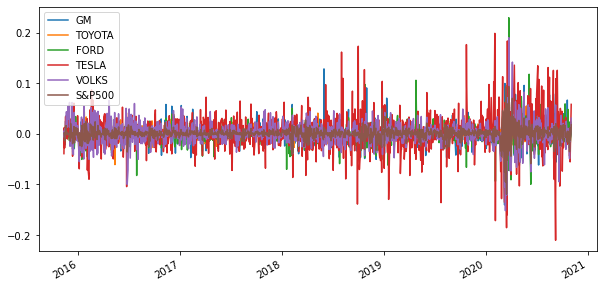

In [11]:
df_daily_returns.plot(figsize=(10,5))

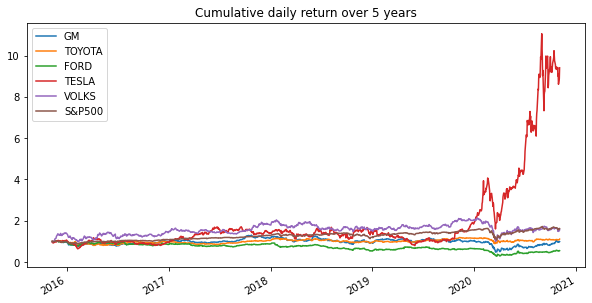

In [12]:
df_cumulative = (1 + df_daily_returns).cumprod()
df_cumulative.plot(figsize=(10,5), title="Cumulative daily return over 5 years")

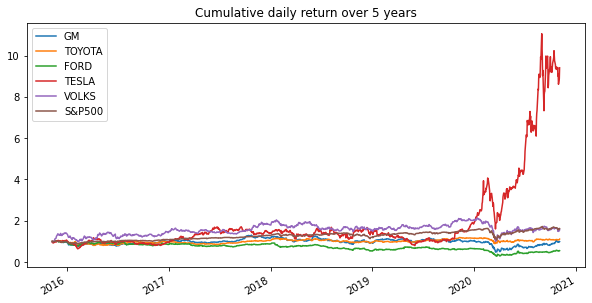

In [13]:
df_cumulative.plot(figsize=(10,5), title="Cumulative daily return over 5 years").get_figure().savefig('cum_5y.png')

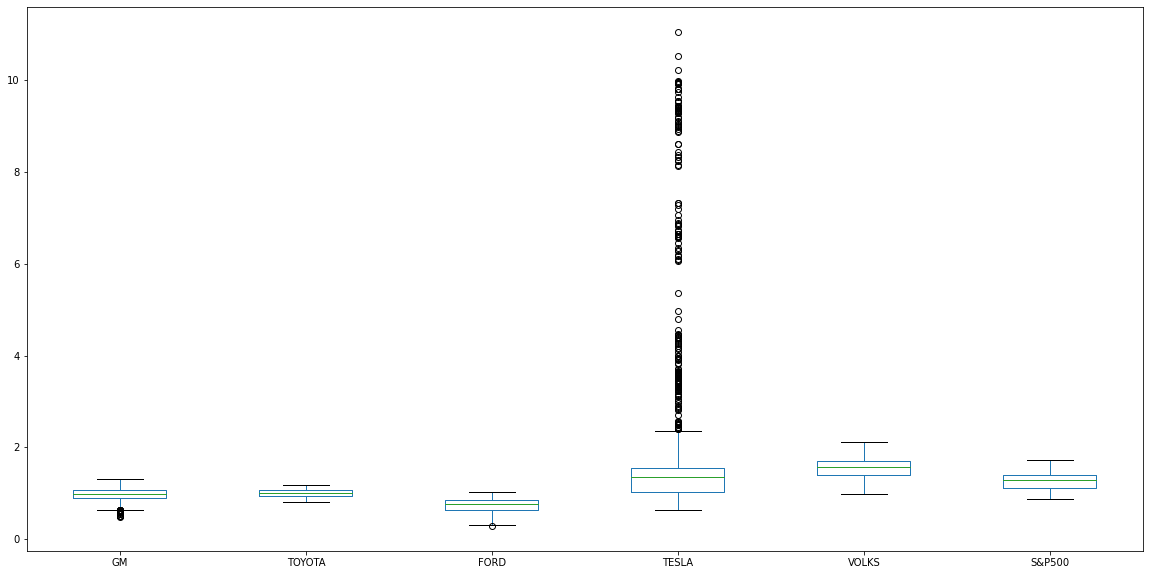

In [14]:
df_cumulative.plot.box(figsize=(20,10))

In [15]:
df_daily_returns.describe()

,GM,TOYOTA,FORD,TESLA,VOLKS,S&P500
count,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000
mean,0.000241,0.000165,-0.000257,0.002434,0.000601,0.000459
std,0.022290,0.012771,0.021049,0.036013,0.022150,0.012171
min,-0.156004,-0.086259,-0.111901,-0.210628,-0.152115,-0.119841
25%,-0.009262,-0.005895,-0.009486,-0.014049,-0.009776,-0.002999
50%,0.000661,0.000186,0.000000,0.001261,0.000000,0.000688
75%,0.009612,0.006824,0.008879,0.018495,0.010980,0.005224
max,0.198751,0.095760,0.229927,0.198949,0.190461,0.093828


In [16]:
###Calculate and plot beta of TESLA and the S&P500.
###Calculate covariance of TESLA
covariance_tesla = df_daily_returns['TESLA'].cov(df_daily_returns['S&P500'])
print(f'TESLA covariance returns vs S&P500 is: {covariance_tesla}')

TESLA covariance returns vs S&P500 is: 0.0001891318155937763


In [17]:
###Calculate variance of S&P500
variance_tesla = df_daily_returns['S&P500'].var()
print(f"Variance of S&P500 is : {variance_tesla}")

Variance of S&P500 is : 0.00014813264676955752


In [18]:
###Calculating beta of Algo 1
###Plot beta trend
beta_tesla = covariance_tesla / variance_tesla
print(f'Beta of TESLA is: {beta_tesla}')

Beta of TESLA is: 1.2767733495506841


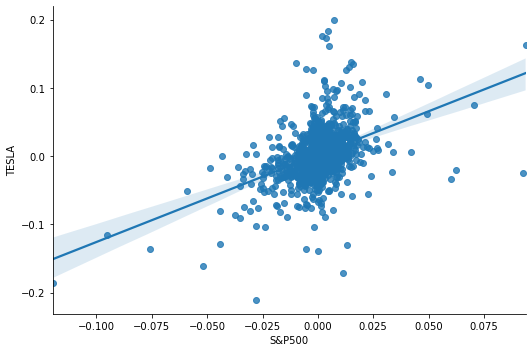

In [19]:
sns.lmplot(x="S&P500", y="TESLA", data=df_daily_returns, aspect=1.5, fit_reg=True)

In [20]:
# Create an empty DataFrame for closing prices
fiveyears_closing_prices = pd.DataFrame()

# Fetch the closing prices of FB and TWTR
fiveyears_closing_prices["Nov/2015"] = all_closing_prices.iloc[0]
fiveyears_closing_prices["Oct/2020"] = all_closing_prices.iloc[-1]
fiveyears_closing_prices["% diff"] = (fiveyears_closing_prices["Oct/2020"] / fiveyears_closing_prices["Nov/2015"]) * 100

fiveyears_closing_prices

,Nov/2015,Oct/2020,% diff
GM,35.670000,35.340000,99.074853
TOYOTA,122.220000,135.760000,111.078383
FORD,14.340000,7.885000,54.986053
TESLA,45.066002,423.899994,940.620370
VOLKS,84.294083,131.740005,156.286184
S&P500,2078.580078,3369.159912,162.089493


In [21]:
 # Use the results to calculate the outcome of our initial $10,000 of investment in Apple and Tesla stocks
initial_investiment = 10000
portfolio_fv = initial_investiment * (fiveyears_closing_prices.iloc[0,2] / 100)
tsla_fv = initial_investiment * (fiveyears_closing_prices.iloc[1,2] / 100)

# Print results
print(f"If you have invested ${initial_investiment} over 5 years in {portfolio_closing_prices.columns} stock your balance would be ${portfolio_fv}"
      f" but if you have invested in tesla instead your balance would be ${tsla_fv}")

If you have invested $10000 over 5 years in Index(['GM', 'TOYOTA', 'FORD'], dtype='object') stock your balance would be $9907.48528174937 but if you have invested in tesla instead your balance would be $11107.838324333168


In [22]:
df_daily_returns.describe()

,GM,TOYOTA,FORD,TESLA,VOLKS,S&P500
count,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000
mean,0.000241,0.000165,-0.000257,0.002434,0.000601,0.000459
std,0.022290,0.012771,0.021049,0.036013,0.022150,0.012171
min,-0.156004,-0.086259,-0.111901,-0.210628,-0.152115,-0.119841
25%,-0.009262,-0.005895,-0.009486,-0.014049,-0.009776,-0.002999
50%,0.000661,0.000186,0.000000,0.001261,0.000000,0.000688
75%,0.009612,0.006824,0.008879,0.018495,0.010980,0.005224
max,0.198751,0.095760,0.229927,0.198949,0.190461,0.093828


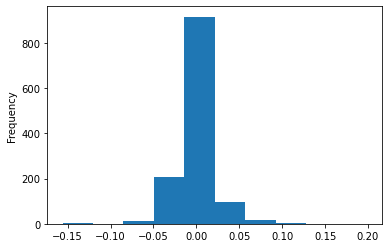

In [23]:
df_daily_returns["GM"].plot.hist()

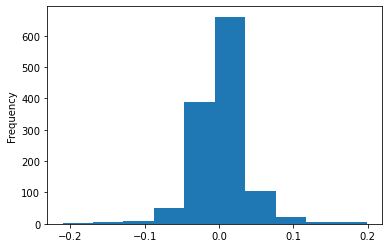

In [24]:
df_daily_returns["TESLA"].plot.hist()

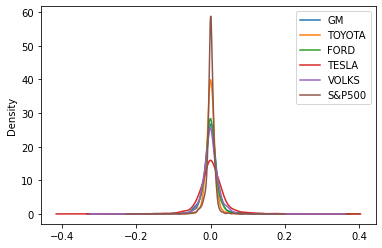

In [25]:
#Plot.density of TESLA and FORD
txl_closing_prices = all_closing_prices.pct_change().dropna()
txl_closing_prices.plot.density()